In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2022-12-05 13:03:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.07s   

2022-12-05 13:03:22 (82.7 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 7s - loss: 0.6639 - accuracy: 0.5811 - val_loss: 0.5824 - val_accuracy: 0.7670 - 7s/epoch - 11ms/step
Epoch 2/30
625/625 - 3s - loss: 0.4324 - accuracy: 0.8302 - val_loss: 0.3831 - val_accuracy: 0.8425 - 3s/epoch - 5ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3071 - accuracy: 0.8788 - val_loss: 0.3518 - val_accuracy: 0.8548 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2547 - accuracy: 0.9014 - val_loss: 0.3430 - val_accuracy: 0.8569 - 2s/epoch - 3ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2187 - accuracy: 0.9161 - val_loss: 0.3495 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1916 - accuracy: 0.9268 - val_loss: 0.3559 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1703 - accuracy: 0.9360 - val_loss: 0.3666 - val_accuracy: 0.8550 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1519 - accuracy: 0.9445 - val_loss: 0.3837 - val_accuracy: 0.8544 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s

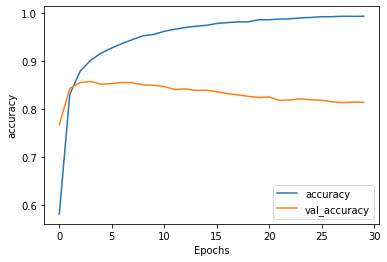

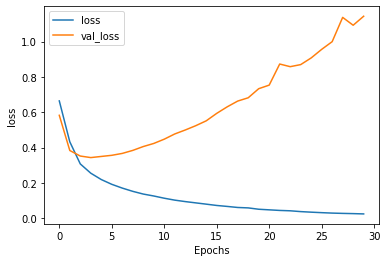

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[0])
print(labels[0])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
former versace store clerk sues over secret 'black code' for minority shoppers
0


In [20]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#if value is near 1,it is sarcastic,if it is near 0 it is not
print(model.predict(padded))

1/1 [==============================] - 0s 17ms/step
[[6.5329361e-01]
 [1.5747626e-06]]
